# Teacher-Student Email Classifier

## CS331 - Artificial Intelligence
### Project - SEM202

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
# To read an Excel file 
df = pd.DataFrame(pd.read_excel("email_dataset.xlsx"))


In [3]:
df.head()

,subject,text,Class
0,CourseXXX Project,Be ready for project.,Assessment
1,CourseXXX: Quiz today,"Since we have two sessions today, quiz 1 will ...",Exam
2,CourseXXX_LC01,Please note that today's class is cancelled. I...,Class-related
3,CourseXXX: Quiz today,Today quiz-2 will start at 10:15 a.m. while cl...,Exam
4,Re: Project,The project is approved.,Assessment


In [4]:
# Create a new dataframe with text and class cols only
df1 = df[['Class', 'text']].copy()

# Remove missing values (NaN) if there any
df1 = df1[pd.notnull(df1['text'])]

df1.head()

,Class,text
0,Assessment,Be ready for project.
1,Exam,"Since we have two sessions today, quiz 1 will ..."
2,Class-related,Please note that today's class is cancelled. I...
3,Exam,Today quiz-2 will start at 10:15 a.m. while cl...
4,Assessment,The project is approved.


In [5]:
# rertieve the unqiue value of Class col
pd.DataFrame(df.Class.unique()).values

array([['Assessment'],
       ['Exam'],
       ['Class-related'],
       ['General']], dtype=object)

In [6]:
# Create a new column 'category_id' which represent the classes as numeric values
df1['category_id'] = df1['Class'].factorize()[0]
category_id_df = df1[['Class', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Class']].values)

# Print the 3 cols (new added col)
df1.head()

,Class,text,category_id
0,Assessment,Be ready for project.,0
1,Exam,"Since we have two sessions today, quiz 1 will ...",1
2,Class-related,Please note that today's class is cancelled. I...,2
3,Exam,Today quiz-2 will start at 10:15 a.m. while cl...,1
4,Assessment,The project is approved.,0


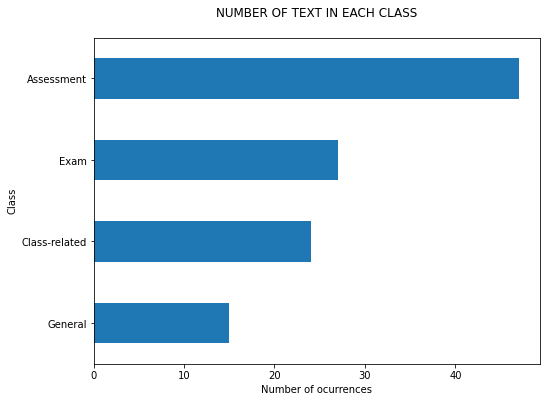

In [7]:
# plotting 
fig = plt.figure(figsize=(8,6))
df1.groupby('Class').text.count().sort_values().plot.barh(
    ylim=0,  title= 'NUMBER OF TEXT IN EACH CLASS\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [8]:
# using the TF-IDF 
# minimum number of ocurrences is 3
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3, ngram_range=(1, 2), stop_words='english')

# to transform each text into a vector
features = tfidf.fit_transform(df1.text).toarray()

labels = df1.category_id

print("Each of the %d texts is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 113 texts is represented by 91 features (TF-IDF score of unigrams and bigrams)


In [9]:
# to find the most correlated terms with each class 
N = 3
for Class, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Class))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Assessment:
  * Most Correlated Unigrams are: submit, assignment, project
  * Most Correlated Bigrams are: midterm exam, course project, assignment uploaded

==> Class-related:
  * Most Correlated Unigrams are: attendance, classes, class
  * Most Correlated Bigrams are: assignment uploaded, tomorrow class, today class

==> Exam:
  * Most Correlated Unigrams are: midterm, exam, quiz
  * Most Correlated Bigrams are: today quiz, final exam, midterm exam

==> General:
  * Most Correlated Unigrams are: did, free, chapter
  * Most Correlated Bigrams are: midterm exam, assignment uploaded, 12 15


In [10]:
# we chose to have 25% as the test data, and 75% as training data

X = df1['text'] 
y = df1['Class'] 

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.25,random_state = 0)

In [11]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [12]:
# to compare between different models 
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.866403,0.056551
LogisticRegression,0.813439,0.060618
MultinomialNB,0.769170,0.053018
RandomForestClassifier,0.787747,0.035397


* seems that LinearSVC is the most accurate model

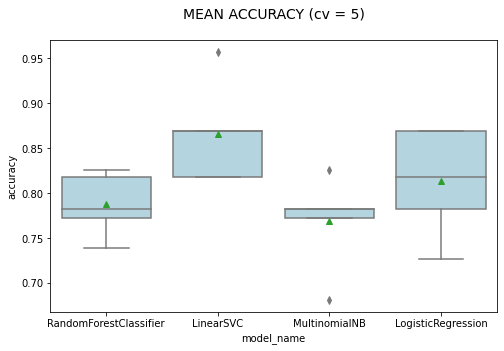

In [13]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', data=cv_df, color='lightblue', showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [14]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df1.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [15]:
# Number of text in test set
X_test.shape

(29, 91)

In [16]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, target_names= df1['Class'].unique()))

				CLASSIFICATIION METRICS

               precision    recall  f1-score   support

   Assessment       1.00      0.90      0.95        10
         Exam       0.71      0.83      0.77         6
Class-related       0.71      0.71      0.71         7
      General       0.67      0.67      0.67         6

     accuracy                           0.79        29
    macro avg       0.77      0.78      0.77        29
 weighted avg       0.80      0.79      0.80        29



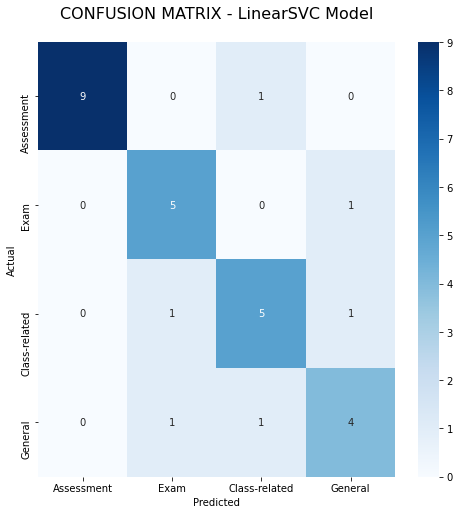

In [17]:
# to show where the miss classification happned
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Class.values, 
            yticklabels=category_id_df.Class.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC Model\n", size=16);

In [18]:
# to show which text is wrongly classified as shown in the matrix
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 1:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
      display(df1.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Class', 'text']])
      print('')

'Class-related' predicted as 'Exam' : 1 examples.


,Class,text
44,Class-related,labs will not start yet



'General' predicted as 'Exam' : 1 examples.


,Class,text
104,General,did you tell the techer about my issue?



'Assessment' predicted as 'Class-related' : 1 examples.


,Class,text
58,Assessment,"If you have any question, ask me by tomorrow c..."



'General' predicted as 'Class-related' : 1 examples.


,Class,text
99,General,Do you have office hour at 12:15 so I can come ?



'Exam' predicted as 'General' : 1 examples.


,Class,text
90,Exam,Are you free today at 8:00 am because I want t...



'Class-related' predicted as 'General' : 1 examples.


,Class,text
91,Class-related,are you free today at 9:15 to take the class.


In [19]:
model.fit(features, labels)

N = 4
for Class, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> %s:" %(Class))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> Assessment:
  * Top unigrams: project, assignment, attached, submit
  * Top bigrams: assignment uploaded, tomorrow class, course project, want ask

==> Class-related:
  * Top unigrams: class, classes, attendance, start
  * Top bigrams: today class, 15 class, tomorrow class, want ask

==> Exam:
  * Top unigrams: quiz, midterm, final, exam
  * Top bigrams: today quiz, final exam, midterm exam, quiz start

==> General:
  * Top unigrams: chapter, free, did, today
  * Top bigrams: 12 15, quiz start, exam syllabus, syllabus provided


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3, ngram_range=(1, 2), stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [21]:
# To test the classifier by writing any email text
email = """Good morning. could you please share the project mark."""
print("The email is: "+email)
print(model.predict(fitted_vectorizer.transform([email])))

The email is: Good morning. could you please share the project mark.
['Assessment']


In [22]:
# if the text is in the dataset, we can compare and check the predicted and the actual category
df1[df1['text'] == email]

,Class,text,category_id


##### Code Resource: https://www.kaggle.com/selener/multi-class-text-classification-tfidf